# Выпускной проект

## Описание задачи

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px; ">
<b> </b>
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
sns.set()

*Поскольку датафреймов будет 4, практически все повторные функции будут находиться в def для упрощения кода. Создам исходные датафреймы по их названию*

In [2]:
def create_df(data):
      return pd.read_csv('/datasets/final_provider/' + data)

df_contract = create_df('contract.csv')
df_personal = create_df('personal.csv')
df_internet = create_df('internet.csv')
df_phone = create_df('phone.csv')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК, данные на базе)

In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Пропусков в данных нет.

2. BeginDate и EndDate данные не в формате Date.

3. По дате необходимо  определить время сотрудничества
    
4. TotalCharges перевести в числовой тип

In [4]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Пропусков в данных нет.

In [5]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Пропусков в данных нет.

2. Данные не по всем клиентам, значит интернетом пользуются только эти пользователи.

In [6]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Пропусков в данных нет.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>И на месте первичный аналитический осмотр. Процедура обыденная. Но позволяет сгенерировать много идей для моедлирования

*Добавлю целевой признак оттока клиента (переводчик говорит что Churn). Если в признаке EndDate присутствует дата, значит клиент ушел, иначе нет. 1 и 0 соответственно*

In [7]:
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')

*Так же известно, что если клиент не ушел, то он продолжает пользоваться услугами на момент 01-02-2020, соответственно замению No на эту дату в признаке EndDate*

In [8]:
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК

*Переведу признаки с датой в формат Date:*

In [9]:
def date_convert(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

date_convert(df_contract, 'BeginDate')
date_convert(df_contract, 'EndDate')

*Найду разницу между BeginDate и EndDate:*

In [10]:
df_contract['duration_in_days'] = (df_contract['EndDate'] - df_contract['BeginDate']).astype('timedelta64[D]')
df_contract['duration_in_days'] = df_contract['duration_in_days'].astype('int')
print(df_contract['duration_in_days'])

0         31
1       1036
2         61
3       1371
4         61
        ... 
7038     730
7039    2191
7040     337
7041     123
7042    2010
Name: duration_in_days, Length: 7043, dtype: int64


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>интересный фактор!

*Переведу TotalCharges в числовой тип:*

In [11]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

*Пропуски появились для 11 клиентов. Рассмотрю подробнее*

In [12]:
df_contract.sort_values(by='TotalCharges').tail(11)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,No,0


*Это клиенты, которые только подключились на момент выгрузки фрейма. Заполню пропуски в TotalCharges на значения MonthlyCharges*

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>точно, новички.

In [13]:
NaN_indexes = df_contract.sort_values(by='TotalCharges').tail(11)['TotalCharges'].index

In [14]:
df_contract.loc[NaN_indexes]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,No,0


*Применю np.where чтобы заполнить пропуски:*

In [15]:
df_contract['TotalCharges'] = np.where(df_contract['TotalCharges'] > 0, \
                                       df_contract['TotalCharges'], df_contract['MonthlyCharges'])

*Найду уникальные значения для категориальных признаков:*

In [16]:
df_contract_categorial = list(df_contract.columns)[3:6]
df_contract_categorial.append('Churn')
df_contract_categorial

['Type', 'PaperlessBilling', 'PaymentMethod', 'Churn']

In [17]:
for i in df_contract_categorial:
    print(i, df_contract[i].unique())

Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


*Напишу функцию строящую график распределения категориального признака:*

In [18]:
def categorial_feature_distribution(df, column):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xticks(rotation=1)
    sns.countplot(x=column, data=df, palette='rocket')
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Количество');

*Построю графики категориальных в df_contract*

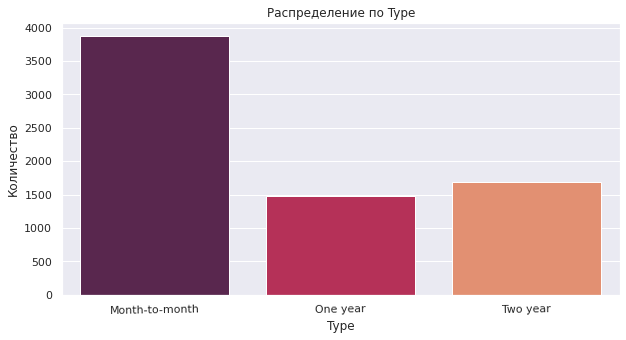

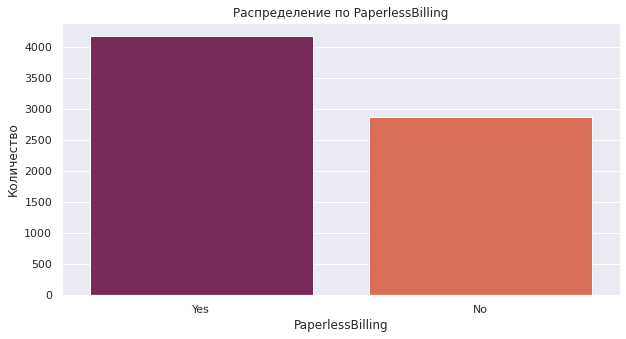

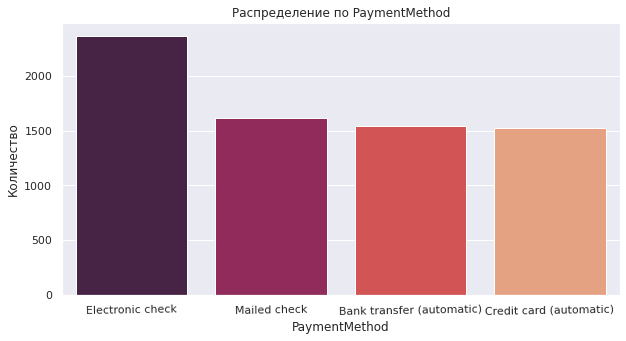

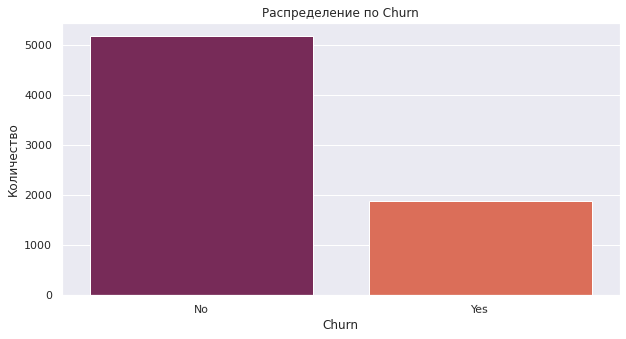

In [19]:
[categorial_feature_distribution(df_contract, item) for item in df_contract_categorial];

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Основной метод оплаты - Month-to-month используют примерно 50% пользователей, два других One yea и Two year используют реже.

2. Использование безбумажной оплаты более популярно.

3. Больше всего используется Electronic check.
    
4. Отток клиентов по сравнению с лояльными достаточно высок.

*Напишу функцию строящую график распределения количественного признака:*

In [20]:
def numeric_feature_distribution(df, column):
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.distplot(df[column])
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Плотность частоты');

*Определим количественные признаки в numeric_features*

In [21]:
numeric_features = list(('MonthlyCharges', 'TotalCharges', 'duration_in_days'))

*Построию графики количественных признаков в df_contract*

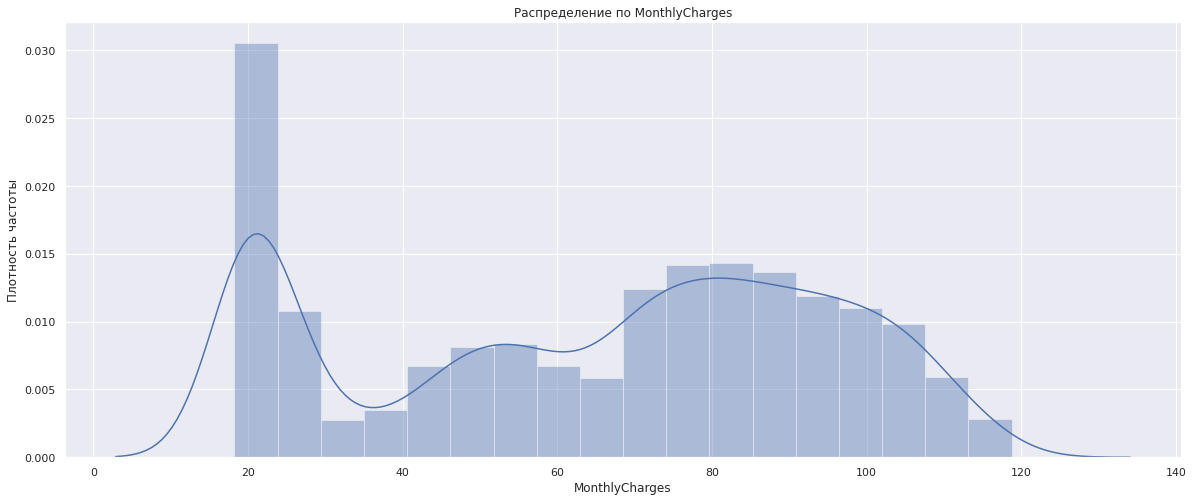

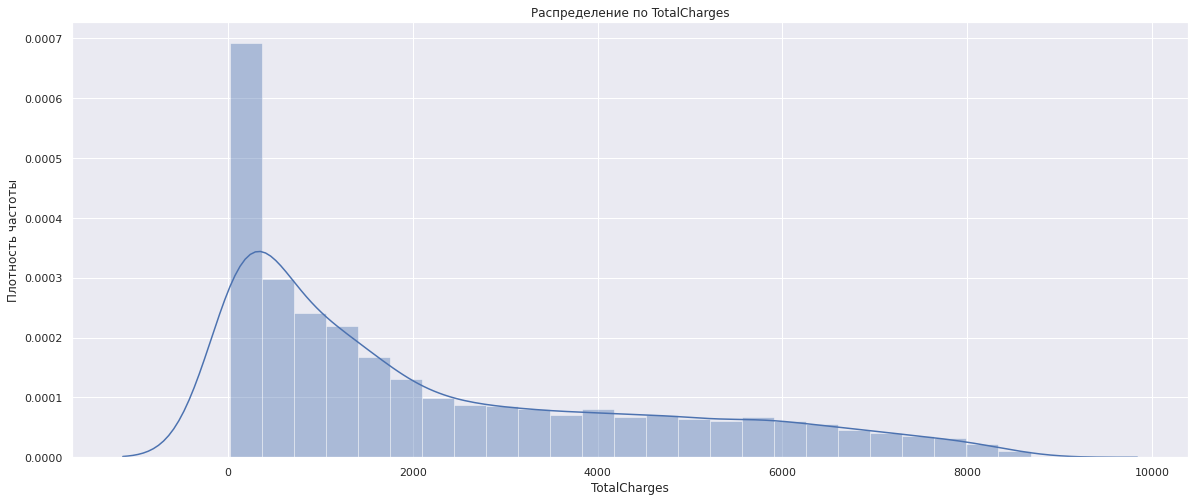

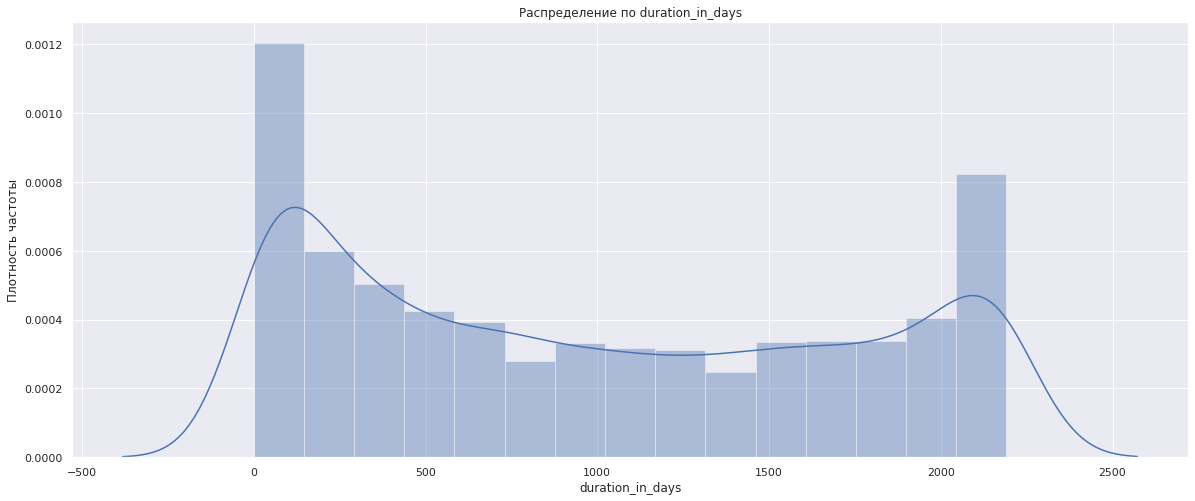

In [22]:
[numeric_feature_distribution(df_contract, item) for item in numeric_features];

In [23]:
for item in numeric_features:
    print(df_contract[item].describe())
    print()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: duration_in_days, dtype: float64



<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. MonthlyCharges - всплески около 20 и 80

2. TotalCharges - нормальное распределение

3. duration_in_days - распределен бимодально, два всплеска - кто пользовался меньше полугода, тех кто больше 3 лет

*Посмотрю как эти признаки коррелируют между собой, с разделением на тех кто ушел и лояльных.*

In [24]:
df_contract.corr()

,MonthlyCharges,TotalCharges,duration_in_days
MonthlyCharges,1.000000,0.651182,0.247754
TotalCharges,0.651182,1.000000,0.826095
duration_in_days,0.247754,0.826095,1.000000


<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Сильно коррелируют duration_in_days и TotalCharges

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
ОК

*Напишу функцию, чтобы посмотреть ушел клиент или лоялен:*

In [25]:
def categorial_countplot(df, categories, nrows, ncols, size=15, rotation=0):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size))
    if nrows == 1 and ncols ==1:
        sns.countplot(df[categories], hue='Churn', data=df, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
        ax.set_title('Распределение по ' + categories)
        ax.set_ylabel('Количество');  
    
    elif nrows == 1:
        for idx, feat in enumerate(categories):
            sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx])
            ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=rotation)
            ax[idx].set_title('Распределение по ' + feat)
            ax[idx].set_ylabel('Количество');  
    
    else:
        for idx, feat in enumerate(categories):
            sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx // ncols, idx % ncols])
            ax[idx//ncols, idx%ncols].set_xticklabels(ax[idx//ncols, idx%ncols].get_xticklabels(), rotation=rotation)
            ax[idx//ncols, idx%ncols].set_title('Распределение по ' + feat)
            ax[idx//ncols, idx%ncols].set_ylabel('Количество');  

*Смотрю для df_contract*

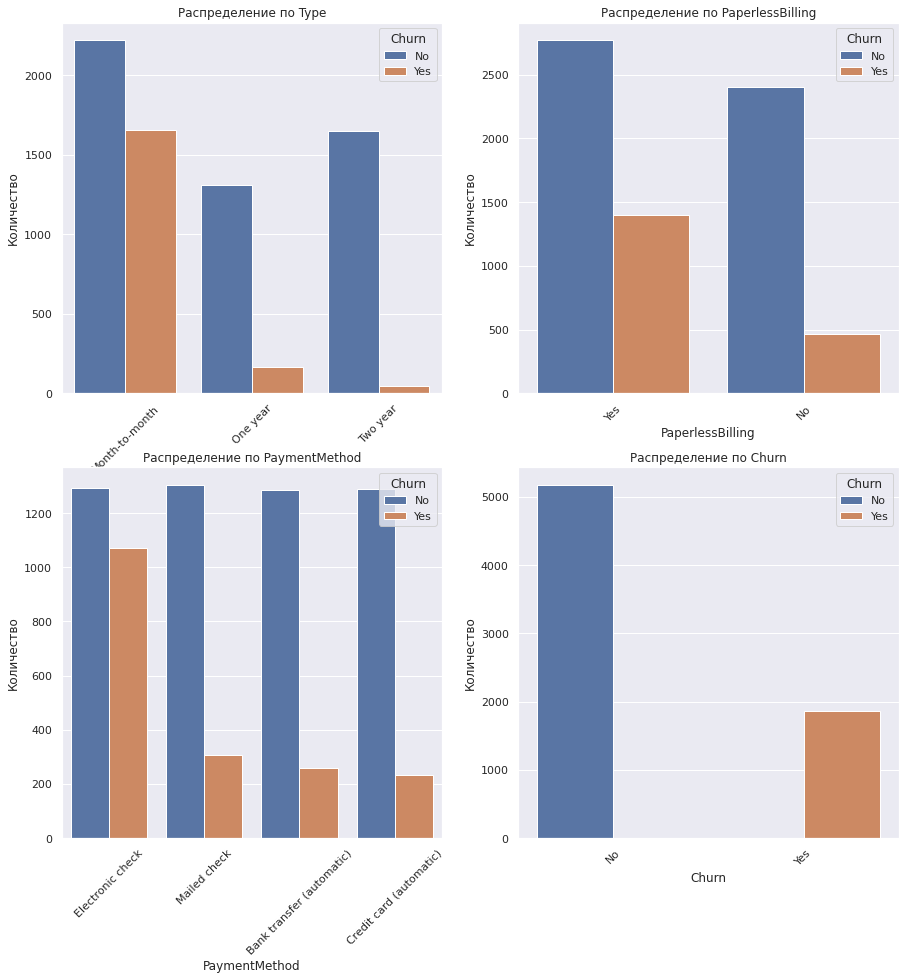

In [26]:
categorial_countplot(df_contract, df_contract_categorial, 2, 2, 15, 45)

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Чаще уходят кто оплачивает помесячно, это и логично, их ничто не держит так долго

2. Оплачивающие через PaperlessBilling более склонны к уходу, чем те, кто оплачивает по бумаге

3. У Electronic check самый высокий отток. Видимо там есть какая то проблема.

*Объединю несколько таблиц по customerID, чтобы более подробно посмотреть зависимости*

In [27]:
df_customerID_churn = pd.DataFrame(df_contract.loc[:, ['customerID', 'Churn']])

In [28]:
df_personal_churn =  df_personal.merge(df_customerID_churn, on='customerID')
df_personal_churn

,customerID,gender,SeniorCitizen,Partner,Dependents,Churn
0,7590-VHVEG,Female,0,Yes,No,No
1,5575-GNVDE,Male,0,No,No,No
2,3668-QPYBK,Male,0,No,No,Yes
3,7795-CFOCW,Male,0,No,No,No
4,9237-HQITU,Female,0,No,No,Yes
...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,No
7039,2234-XADUH,Female,0,Yes,Yes,No
7040,4801-JZAZL,Female,0,Yes,Yes,No
7041,8361-LTMKD,Male,1,Yes,No,Yes


In [29]:
df_internet_churn =  df_internet.merge(df_customerID_churn, on='customerID')
df_internet_churn

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes,No
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No,Yes


In [30]:
df_phone_churn =  df_phone.merge(df_customerID_churn, on='customerID')
df_phone_churn

,customerID,MultipleLines,Churn
0,5575-GNVDE,No,No
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,No
...,...,...,...
6356,2569-WGERO,No,No
6357,6840-RESVB,Yes,No
6358,2234-XADUH,Yes,No
6359,8361-LTMKD,Yes,Yes


*Выберу категории в df_personal и сохраню в personal_churn_cat, по которым буду искть зависимости*

In [31]:
personal_churn_cat = df_personal_churn.columns[1:5]
personal_churn_cat

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

*Ну и собственно сами распределения и зависимости данных*

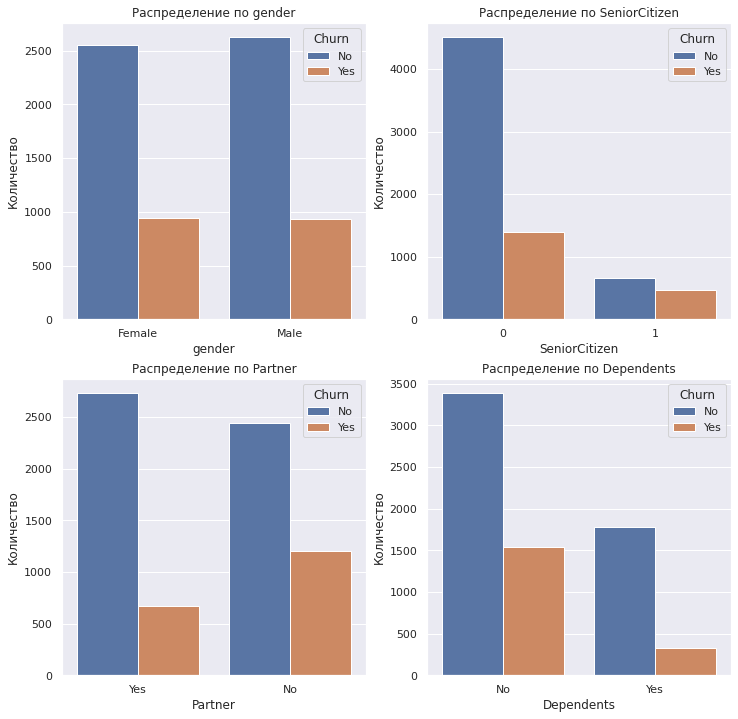

In [32]:
categorial_countplot(df_personal_churn, personal_churn_cat, 2, 2, 12, 0)

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. По полу практически нет различий, это и логично.

2. Пенсионеры уходят достаточно часто

3. Также часто уходят одиночки

4. Пользователи с детьми достаточно лояльны

*Такой же механизм рассмотрю для internet_churn_cat и phone_churn_cat*

In [33]:
internet_churn_cat = df_internet_churn.columns[1:8]
internet_churn_cat

Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

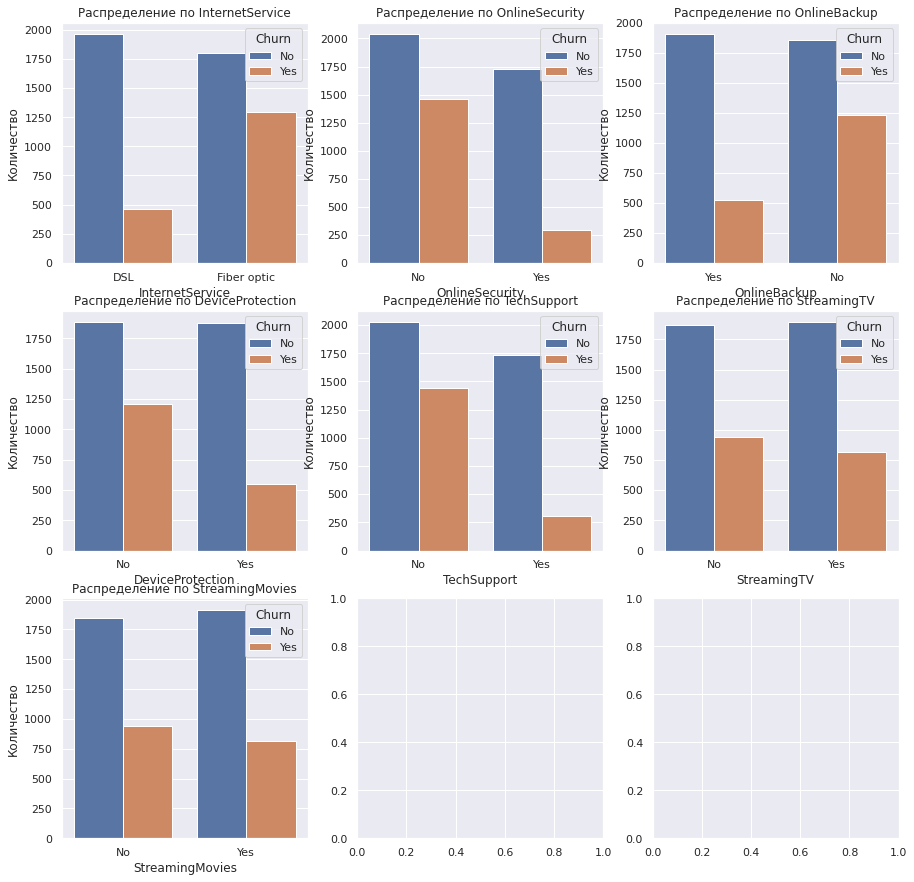

In [34]:
categorial_countplot(df_internet_churn, internet_churn_cat, 3, 3)

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. DSL видимо работает стабильнее, чем Fiber optic, поэтому там меньше пользователей уходит

2. Online Security работает хорошо, поэтому те, у кого она есть не уходят, может быть целесообразно включить её в цену тарифа, вопрос на подумать

3. Streaming Movies сильно не играет роли в выборе пользователей

*Посмотрю, как влияет распределение по подключению к нескольким линиям одновременно.*

In [35]:
phone_churn_cat = df_phone.columns[1]
phone_churn_cat

'MultipleLines'

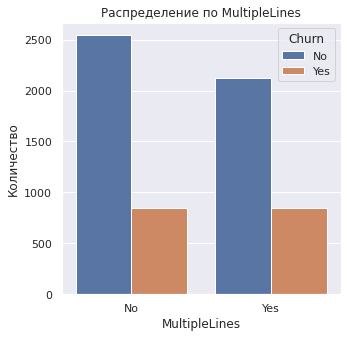

In [36]:
categorial_countplot(df_phone_churn, phone_churn_cat, 1, 1, size=5, rotation=0)

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. Данный признак не влияет на отток клиентов

*Посмотрю на лояльных и ушедших пользователей телефонии и интернета. Объеденю несколько таблиц.*

In [37]:
df_internet_users = df_contract.merge(df_internet, on='customerID', how='outer')
df_phone_users = df_contract.merge(df_phone, on='customerID', how='outer')
df_internet_users

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,No,730,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,No,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,No,337,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,123,Fiber optic,No,No,No,No,No,No


In [38]:
df_phone_users

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,No
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,No,730,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,No,2191,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,No,337,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,123,Yes


*Не пользующиеся это NaN. Заполню пропуски:*

In [39]:
df_internet_users['InternetService'] = df_internet_users['InternetService'].fillna(-1)
df_phone_users['MultipleLines'] = df_phone_users['MultipleLines'].fillna(-1)

df_internet_users['internet_user'] = df_internet_users['InternetService'].apply(lambda x: 0 if x == -1 else 1)
df_phone_users['df_phone_users'] = df_phone_users['MultipleLines'].apply(lambda x: 0 if x == -1 else 1)

In [40]:
df_internet_users

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet_user
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,DSL,No,Yes,No,No,No,No,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,DSL,Yes,No,Yes,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,DSL,Yes,No,Yes,Yes,No,No,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Fiber optic,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,No,730,DSL,Yes,No,Yes,Yes,Yes,Yes,1
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,No,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,1
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,No,337,DSL,Yes,No,No,No,No,No,1
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,123,Fiber optic,No,No,No,No,No,No,1


In [41]:
df_phone_users

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,MultipleLines,df_phone_users
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,-1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,No,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,No,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,-1,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,No,730,Yes,1
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,No,2191,Yes,1
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,No,337,-1,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,123,Yes,1


*Для наглядности данных лучше всего подойдут круговые диаграммы*

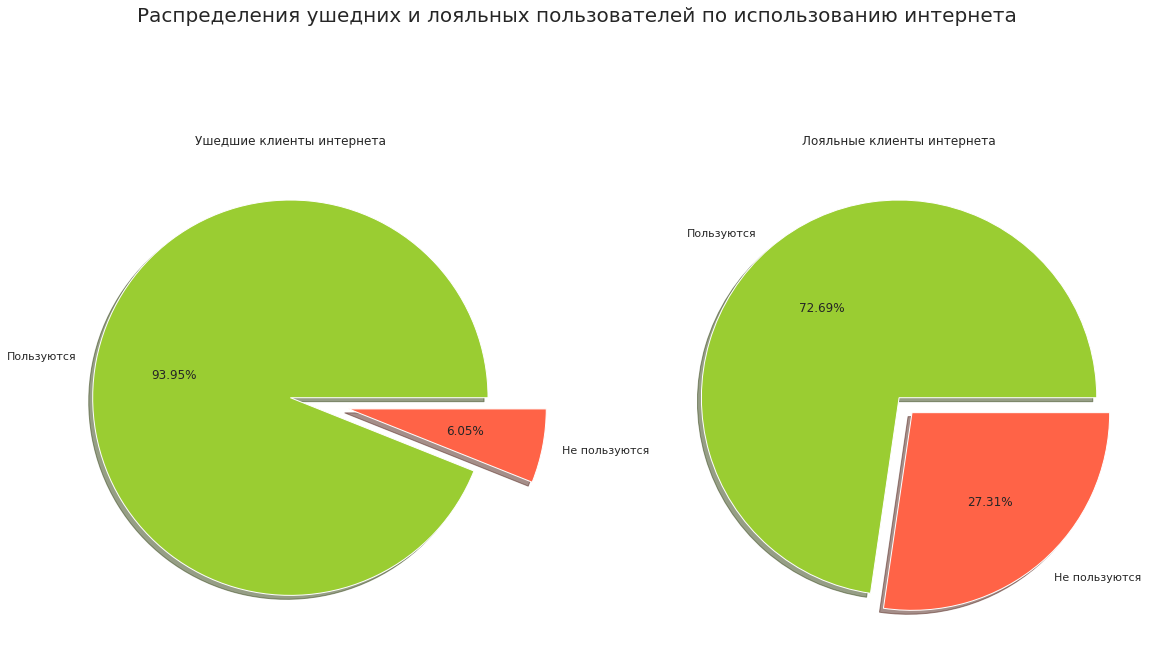

In [42]:
plt.figure(1, figsize=(20,20))
the_grid = GridSpec(2, 2)

colors = ['yellowgreen', 'tomato']


plt.subplot(the_grid[0, 0], aspect=1, title='Ушедшие клиенты интернета')
plt.pie(df_internet_users[df_internet_users['Churn'] == 'Yes']['internet_user'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.3))


plt.subplot(the_grid[0, 1], aspect=1, title='Лояльные клиенты интернета')
plt.pie(df_internet_users[df_internet_users['Churn'] == 'No']['internet_user'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.1))

plt.suptitle('Распределения ушедних и лояльных пользователей по использованию интернета', fontsize=20)


plt.show()

*Тоже самое для телефонии:*

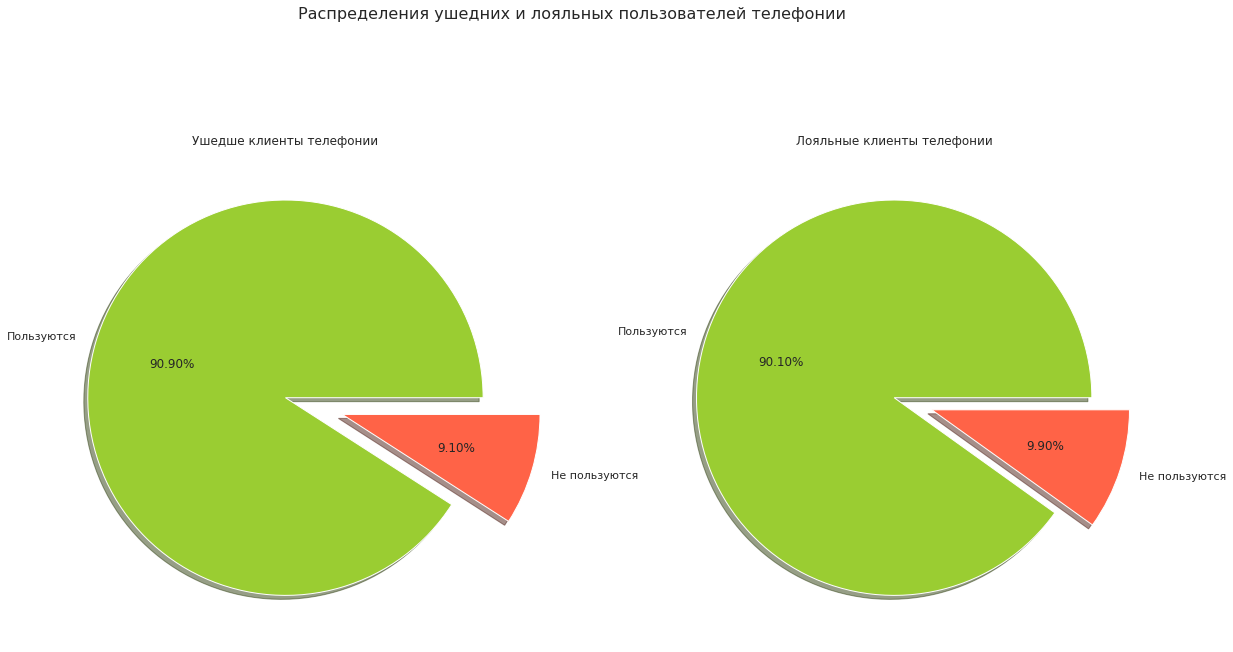

In [43]:
plt.figure(1, figsize=(20,20))
the_grid = GridSpec(2, 2)

colors = ['yellowgreen', 'tomato']


plt.subplot(the_grid[0, 0], aspect=1, title='Ушедше клиенты телефонии')
plt.pie(df_phone_users[df_phone_users['Churn'] == 'Yes']['df_phone_users'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.3))


plt.subplot(the_grid[0, 1], aspect=1, title='Лояльные клиенты телефонии')
plt.pie(df_phone_users[df_phone_users['Churn'] == 'No']['df_phone_users'].value_counts(), 
                     labels=['Пользуются', 'Не пользуются'], autopct='%.2f%%', shadow=True, colors=colors, explode = (0, 0.2))

plt.suptitle('Распределения ушедних и лояльных пользователей телефонии', fontsize=16)

plt.show()

<div style="border-radius: 10px 55 10px; border: 1px solid blue; padding: 5px; ">
Выводы:
    
1. У лояльных клиентов чаще уходят те, кто не пользуется интернетом

2. По телефонии дела обстоят примерно одинаково

### Выводы по главе

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px; ">

1. Чаще уходят в основном те, кто получает большие счета за услуги
    
2. Чаще уходят те, кто оплачивает помесячно и оплачивающие по средством PaperlessBilling

3. У Electronic check высокий отток клиентов. Есть какая то проблема.

4. Единичные пользователи уходят чаще, чем пары и семьи с детьми.
    
5. Пользователи DSL уходят реже
    
6. OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport полезные фичи, им доверяют люди.

7. У лояльных клиентов чаще уходят те, кто не пользуется интернетом

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
СУПЕР АНАЛИТИКА!!!!!!!!!. <br>
    
Замечу только, что графический анализ - это предположение/гипотеза о влиянии факторв на целевую.  И чтобы подтвердить/опровергнуть его - применяют аналитические методы проверки гипотез (спринт 4, например).

## Подготовка данных для обучения моделей

*Объеденю все таблицы по стобцу customerID используя merge()*

In [44]:
df_full = df_contract.merge(df_personal, on='customerID', how='outer') \
                     .merge(df_internet, on='customerID', how='outer') \
                     .merge(df_phone, on='customerID', how='outer')
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


*Заменю значения целевого признака на (0, 1):*

In [45]:
df_full['Churn'] = df_full['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df_full

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duration_in_days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК

*Добавлю еще два признака:*

*constant_person - постоянные люди, они оплачивают счета на 1, 2 года вперед*

*vip_client - клиенты, тратящие много по месячным отчислениям и длительностью контракта больше 1 года.*

In [46]:
df_full['constant_person'] =  df_full['Type'].apply(lambda x: 0 if x == 'Month-to-month' else 1)

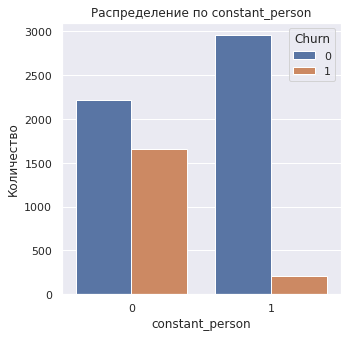

In [47]:
categorial_countplot(df_full, 'constant_person', 1, 1, 5)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>таааак)

*Непостоянные гораздо более склонны к уходу/смене оператора*

In [48]:
quantile_3 =  df_full['MonthlyCharges'].quantile(.75)
quantile_3

89.85

*Добавлю столбец vip_client*

In [49]:
def vip_client(row):
    MonthlyCharges = row['MonthlyCharges']
    duration_in_days = row['duration_in_days']

    if MonthlyCharges > quantile_3 and duration_in_days > 365:
        return 'Yes'

    return 'No'

df_full['vip_client'] = df_full.apply(vip_client, axis=1)

In [50]:
df_full['vip_client'].value_counts()

No     5505
Yes    1538
Name: vip_client, dtype: int64

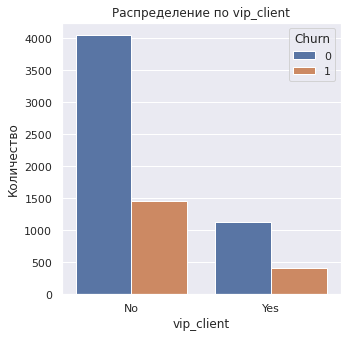

In [51]:
categorial_countplot(df_full, 'vip_client', 1, 1, 5)

*Разницы особо нет, уходят и тех практически с одинаковой частотой*

*Удалю ненужные признаки для обучения*

In [52]:
df_full = df_full.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
ОТЛИЧНО, что удаляешь факторы-даты!!!!! Если у нас тема НЕ временные ряды, то такие факторы лучше не использовать. Они "нагонят" метрики, но бизнес-эффективность модели  - рухнет.

*Из давнишних уроков восполюсь техникой One-Hot Encoding, OHE,а  pd.get_dummies() поможет избежать дамми-ловушки*

In [53]:
df_ohe = pd.get_dummies(df_full, drop_first=True)
df_ohe

,MonthlyCharges,TotalCharges,Churn,duration_in_days,SeniorCitizen,constant_person,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,vip_client_Yes
0,29.85,29.85,0,31,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,56.95,1889.50,0,1036,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0
2,53.85,108.15,1,61,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0
3,42.30,1840.75,0,1371,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0
4,70.70,151.65,1,61,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,0,730,0,1,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0
7039,103.20,7362.90,0,2191,0,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,1,1,1
7040,29.60,346.45,0,337,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0
7041,74.40,306.60,1,123,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0


*Теперь можно разделить датафрейм на обучающую и тестовую выбороки. Из опыта прошлых проектов пропорции будут 4:1*

In [54]:
df_train, df_test = train_test_split(df_ohe, test_size=0.2, random_state=12345)

*Разделю выборки на X - признаки и y — целевой признак.*

In [55]:
df_train.shape, df_test.shape

((5634, 24), (1409, 24))

In [56]:
X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn']
X_test = df_test.drop(['Churn'], axis=1)
y_test = df_test['Churn']

In [57]:
numeric_features = X_train.iloc[:, :3].columns
numeric_features

Index(['MonthlyCharges', 'TotalCharges', 'duration_in_days'], dtype='object')

*Проведу стандартизацию данных через StandardScaler.*

In [58]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
радельное масштабирование, ОК.

*Посмотрим на отношение лояльных к ушедшим*

In [59]:
scale_pos_weight = round((len(y_train[y_train == 0]) / 
                          len(y_train[y_train == 1])), 3)
scale_pos_weight

2.781

*Целевой признак ухода представлен в меньшей степени. Выполню upsample, чтобы выровнять признаки, такая функция уже была в предыдущих проектах, поэтому ей и воспользуюсь*

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Да, разбаланс виден. Чаще всего границу принимают на уровне 0.25-0.30 , всё, что ниже - однозначно в балансировку). А так - на усмотрение аналитика.

In [60]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

*Применю upsample к обучающей выборке и проверю значения*

In [61]:
X_train_ups, y_train_ups = upsample(X_train, y_train, 3)

print(X_train_ups.shape)
print(y_train_ups.shape)

(8614, 23)
(8614,)


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>верно, балансировка только трайна!

In [62]:
scale_pos_weight = round((len(y_train_ups[y_train_ups == 0]) / 
                          len(y_train_ups[y_train_ups == 1])), 3)
scale_pos_weight

0.927

*Отлично, дисбаланс признаков устранен*

### Выводы по главе

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px; ">
    
1. Устранен дисбаланс целевого признака
    
2. Категориальеные признаки перевел в численные, количественные нормировал
    
3. Добавлены еще 2 признака
    
4. Модели подготовлены к обучению

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>Самое сложное позади, впереди только моделирование)

## Обучение моделей

*В качестве основных моделей использую самые популярные: **LogisticRegression** и **RandomForestClassifier**.*

*Для повышения качества метрики AUС_ROC попробую **CatBoostClassifier**, **XGBClassifier**, **LGBMClassifier**.*

*Для подбора гиперпараметров буду использовать готовые функции GridSearchCV.*

*Для кросс-валидации при подборе гиперпараметров ShuffleSplit.*

In [63]:
def model_learning(model, parameters):
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(X_train_ups, y_train_ups)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    return grid_model.best_estimator_

*Для оценки качества модели также буду использовать готовую функцию, которая строит ROC-AUC и Accuracy - test_scoring. Он будет принимать на вход обученную модель и строить ROC-кривую*

In [64]:
def test_scoring(model):
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    pred_test = model.predict(X_test)
    print('Accuracy: ', round(model.score(X_test, y_test), 3))
    print('Presicion: ', round(precision_score(y_test, pred_test), 3))
    print('Recall: ', round(recall_score(y_test, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(y_test, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

Лучшая оценка на валидации:  0.8491423602543419
Лучшие гиперпараметры модели на валидации:  {'C': 1.0535263157894736}
Лучшая модель:  LogisticRegression(C=1.0535263157894736, n_jobs=-1, random_state=12345)
Accuracy:  0.732
Presicion:  0.501
Recall:  0.839
AUC-ROC:  0.842


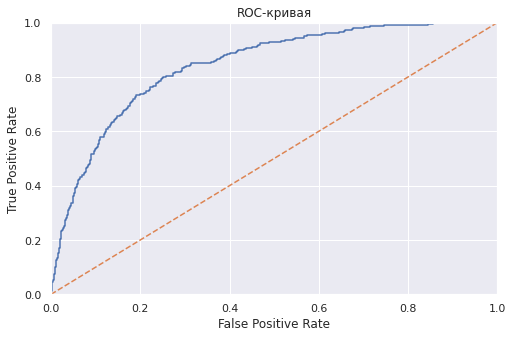

CPU times: user 23.8 s, sys: 1min 12s, total: 1min 35s
Wall time: 1min 36s


In [65]:
%%time
lr = LogisticRegression(random_state=12345, n_jobs=-1)
lr_param = {'C' : np.linspace(0.001, 10, 20)}

lr_fitted = model_learning(lr, lr_param)
test_scoring(lr_fitted)

Лучшая оценка на валидации:  0.979081252995996
Лучшие гиперпараметры модели на валидации:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Лучшая модель:  RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=12345)
Accuracy:  0.803
Presicion:  0.637
Recall:  0.625
AUC-ROC:  0.845


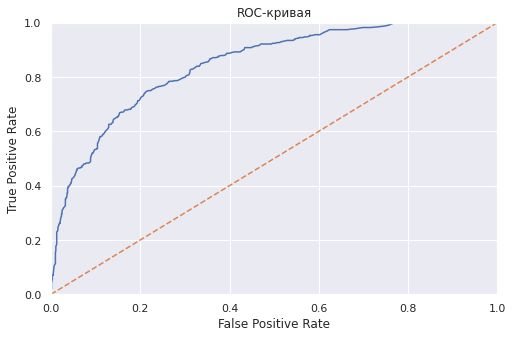

CPU times: user 50 s, sys: 152 ms, total: 50.2 s
Wall time: 50.4 s


In [66]:
%%time
rf = RandomForestClassifier(random_state=12345, n_jobs=-1)
rf_param = {'n_estimators': [300],
            'max_depth': [None],
            'min_samples_leaf': np.arange(1, 6, 2),
            'min_samples_split': np.arange(2, 7, 2)}

rf_fitted = model_learning(rf, rf_param)
test_scoring(rf_fitted)

*Пояснения данных:*

n_estimators - количество решающих деревьев

learning_rate - коэффициент шага антиградиента

max_depth - глубина дерева

l2_leaf_reg - коеффициент при l2 регуризации

*Обучение моделей производится на тестовой выборке*

Лучшая оценка на валидации:  0.9448625192858868
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x7fc9ba4501c0>
Accuracy:  0.797
Presicion:  0.599
Recall:  0.741
AUC-ROC:  0.869


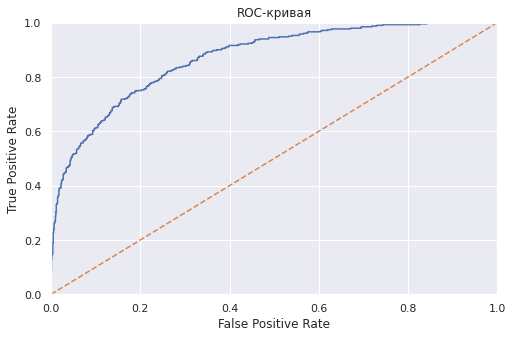

CPU times: user 5.25 s, sys: 61.3 ms, total: 5.31 s
Wall time: 8.94 s


In [67]:
%%time
CatBoost_clf = CatBoostClassifier(random_state=12345, verbose=0)
CatBoost_clf_param = {'n_estimators': [100],
                      'learning_rate': [0.1],
                      'max_depth': [9],
                      'l2_leaf_reg': [1]}

CatBoost_fitted = model_learning(CatBoost_clf, CatBoost_clf_param)
test_scoring(CatBoost_fitted)

[17:23:54] WARNING: ../src/learner.cc:576: 
Parameters: { "l2_leaf_reg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:23:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:49] WARNING: ../src/learner.cc:576: 
Parameters: { "l2_leaf_reg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:25:51] WARNING: ../s

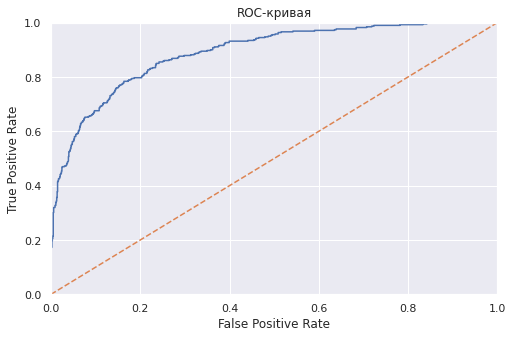

CPU times: user 8min 29s, sys: 7.98 s, total: 8min 37s
Wall time: 8min 40s


In [68]:
%%time
xgb_clf = XGBClassifier(random_state=12345, n_jobs=-1)
xgb_clf_param = {'n_estimators': [100],
                  'learning_rate': [0.1],
                  'max_depth': [9],
                  'l2_leaf_reg': [1]}

xgb_clf_fitted = model_learning(xgb_clf, xgb_clf_param)
test_scoring(xgb_clf_fitted)

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
Лучшая оценк

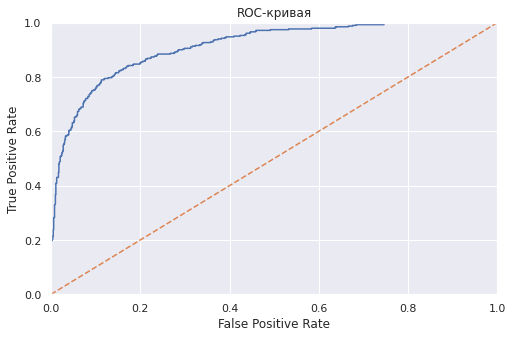

CPU times: user 9min 58s, sys: 7.49 s, total: 10min 5s
Wall time: 10min 9s


In [69]:
%%time
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=12345)
lgbm_clf_param = {'n_estimators': [100],
                  'learning_rate': [0.1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}
    
lgbm_clf_fitted = model_learning(lgbm_clf, lgbm_clf_param)
test_scoring(lgbm_clf_fitted)

*P.S. После перекомпиляции проекта модели могут считаться очень долго, поэтому дальше я создам таблицы со всеми показателями моделей. И буду использовать чуть разные показатели, потому что модели считаются ооочень долго. Данные в таблице будут приведены для значений*
'n_estimators': [300],
'learning_rate': [0.1],
'max_depth': [9],
'l2_leaf_reg': [1]}. 

Хотя наилучшие показатели были 'n_estimators': [больше тысячи],
'learning_rate': [0.1],
'max_depth': [9],
'l2_leaf_reg': [1]}. Расчёт моделей уходил на часы и есть возможность добиться ещё большего результата.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>спасибо!

In [70]:
data = {'Модель':['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier'], 
        'Accuracy': [0.732, 0.803, 0.845, 0.828, 0.864],
        'Presicion': [0.501, 0.637, 0.728, 0.656, 0.725],
        'Recall':[0.839, 0.625, 0.678, 0.76, 0.794],
        'AUC-ROC': [0.842, 0.845, 0.892, 0.889, 0.92],
        'Время обучения': ['37s', '48s', '53s', '4min 3s', '8min 56s']}

pd.DataFrame(data)

,Модель,Accuracy,Presicion,Recall,AUC-ROC,Время обучения
0,LogisticRegression,0.732,0.501,0.839,0.842,37s
1,RandomForestClassifier,0.803,0.637,0.625,0.845,48s
2,CatBoostClassifier,0.845,0.728,0.678,0.892,53s
3,XGBClassifier,0.828,0.656,0.760,0.889,4min 3s
4,LGBMClassifier,0.864,0.725,0.794,0.920,8min 56s


### Выводы по главе

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px; ">
    
1. LogisticRegression показала наименьшие значения Accuracy и  AUC-ROC, но сильно опережает по во времени обучения
    
2. RandomForestClassifier чуть лучше, но дольше обучается, особенно с большим числом деревьев.
    
3. Лучшие по качеству показателей - модели градиентного бустинга, но они очень долго обучаются.
    
4. Лучшая модель по значению AUC-ROC - LGBMClassifier

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>
ОК, Николай, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, размышления над факторами, многогранная модельная работа, конечные результаты - многое удалось как надо<br> 
А что совсем хорошо, так это то, что не стал гнаться за точностью любой ценой, даже ценой наружения бизнес-логики. (это я про даты-признаки, многие их вставляют...)<br>

Прежде, чем идти дальше, напомню из прошлых наших общений основные моменты, которые бы мне хотелось зафиксировать, как важные для момделирования (что-то ты и так хорошо используешь):<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- Оцениваем мультиколлинеарность.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.<br><br><br>

<font color='red'>
Есть пару-тройку вопросов для дополнений:<br>
1)При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее) У тебя расчёт есть, но выводы не обозначены чётко.<br>
2) Будет здорово, если построишь график важности факторов.<br><br>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти два пункта - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert" style="border-color: red; border-radius: 5px">
    <p><u><b> КОММЕНТАРИЙ СТУДЕНТА</b></u></p>
    
*Николай, спасибо большое за положительне отзывы о проекте, всегда приятно слышать добрые слова. Согласен с тобой. Постараюсь правильно понять твои дополнения. Начну со 2 вопроса, это важность факторов. Для этого напишу функцию, принимающая обученную модель и выводящую признаки, ранжированные по значимости для модели. Надеюсь это то, что нужно.*

In [71]:
def feature_importances(model):
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Важность', fontsize=25, weight = 'bold')
    plt.ylabel('Признаки', fontsize=25, weight = 'bold')
    plt.title('Важность признаков', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

*Для модели важность признака определяется абсолютным значением его коэффициента.
Посчитаем долю влияния каждого признака на предсказание модели LogisticRegression, воспользуясь функцией softmax:*

In [72]:
m = softmax(abs(lr_fitted.coef_))
m[0]

array([0.03667898, 0.06102291, 0.11335196, 0.04095104, 0.06252772,
       0.02995112, 0.06419181, 0.04495662, 0.0323877 , 0.04157668,
       0.03454044, 0.02985973, 0.0298341 , 0.03783834, 0.04685861,
       0.04278913, 0.03233174, 0.03097799, 0.03996045, 0.03820051,
       0.03672106, 0.03084563, 0.04164571])

*У модели LogisticRegression нет метода featureimportances, воспользуюсь готовым кодом и заменю значение на полученное выше*

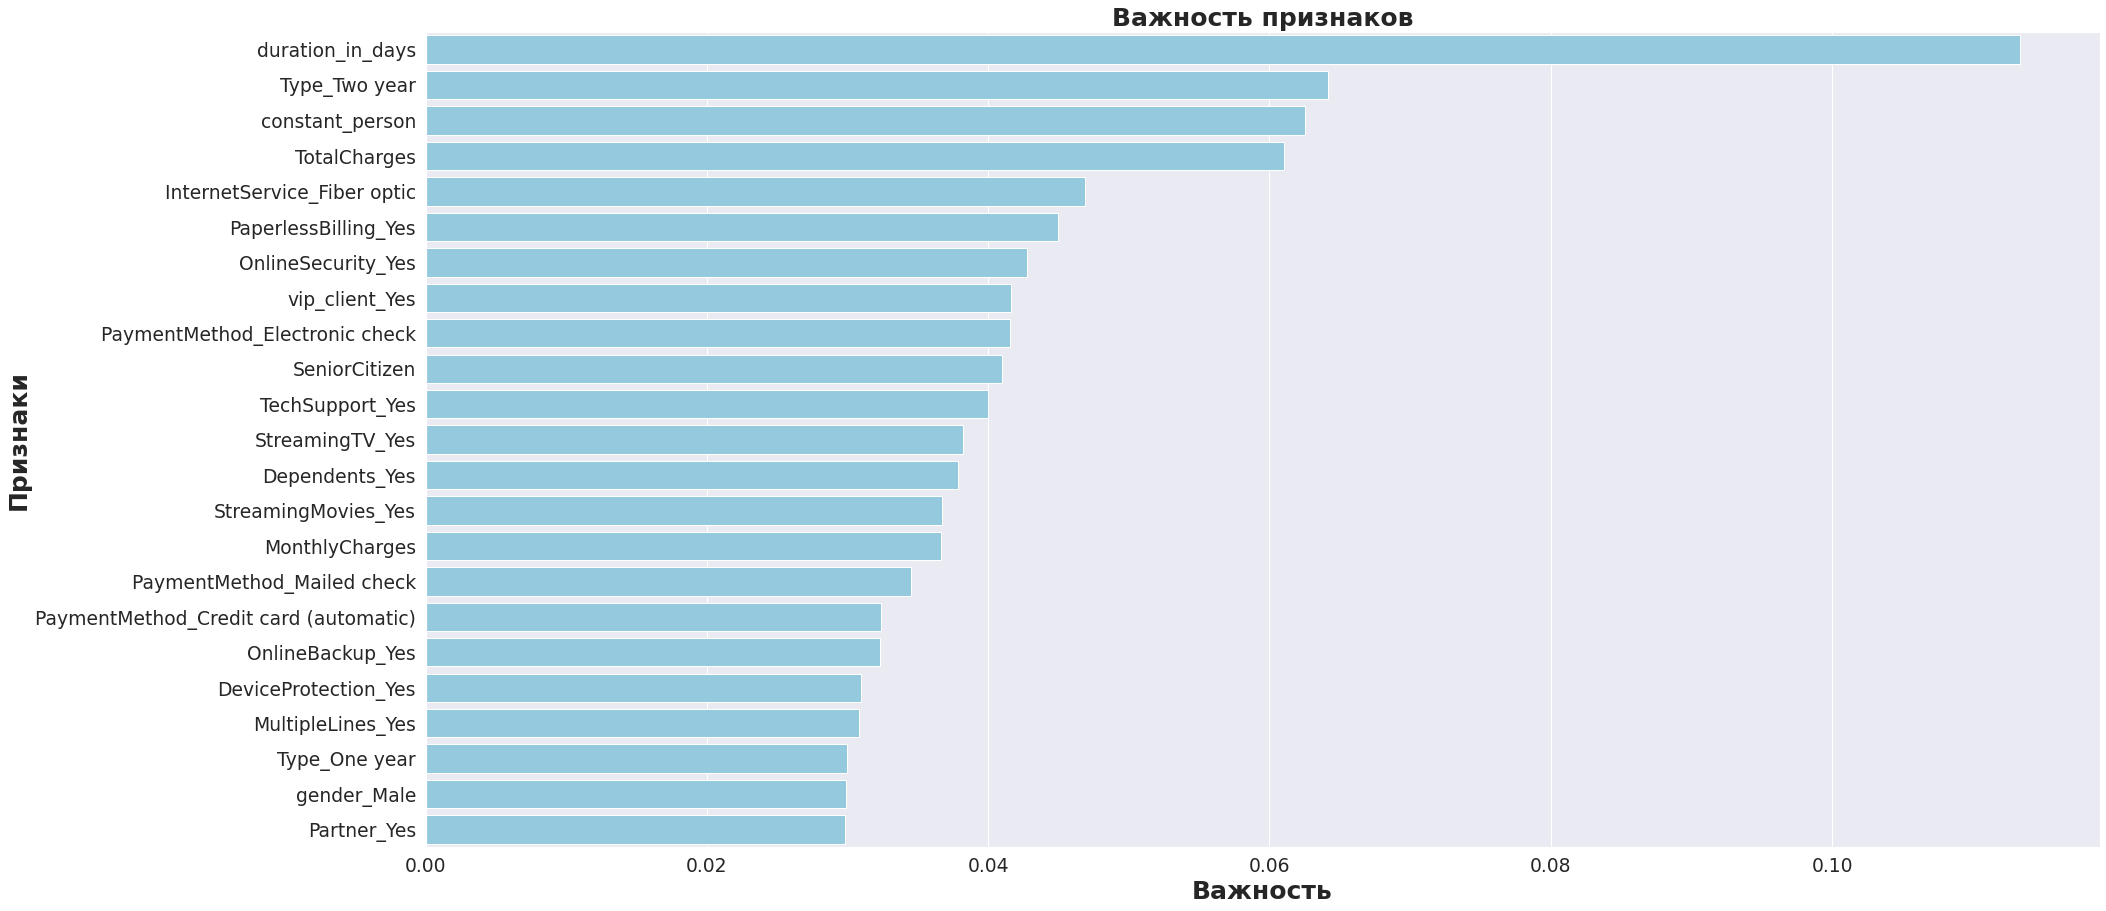

None

,Features,Gini-Importance
0,duration_in_days,0.113352
1,Type_Two year,0.064192
2,constant_person,0.062528
3,TotalCharges,0.061023
4,InternetService_Fiber optic,0.046859
5,PaperlessBilling_Yes,0.044957
6,OnlineSecurity_Yes,0.042789
7,vip_client_Yes,0.041646
8,PaymentMethod_Electronic check,0.041577
9,SeniorCitizen,0.040951


In [73]:
feats = {}
for feature, importance in zip(X_train.columns, m[0]):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

**RandomForest**

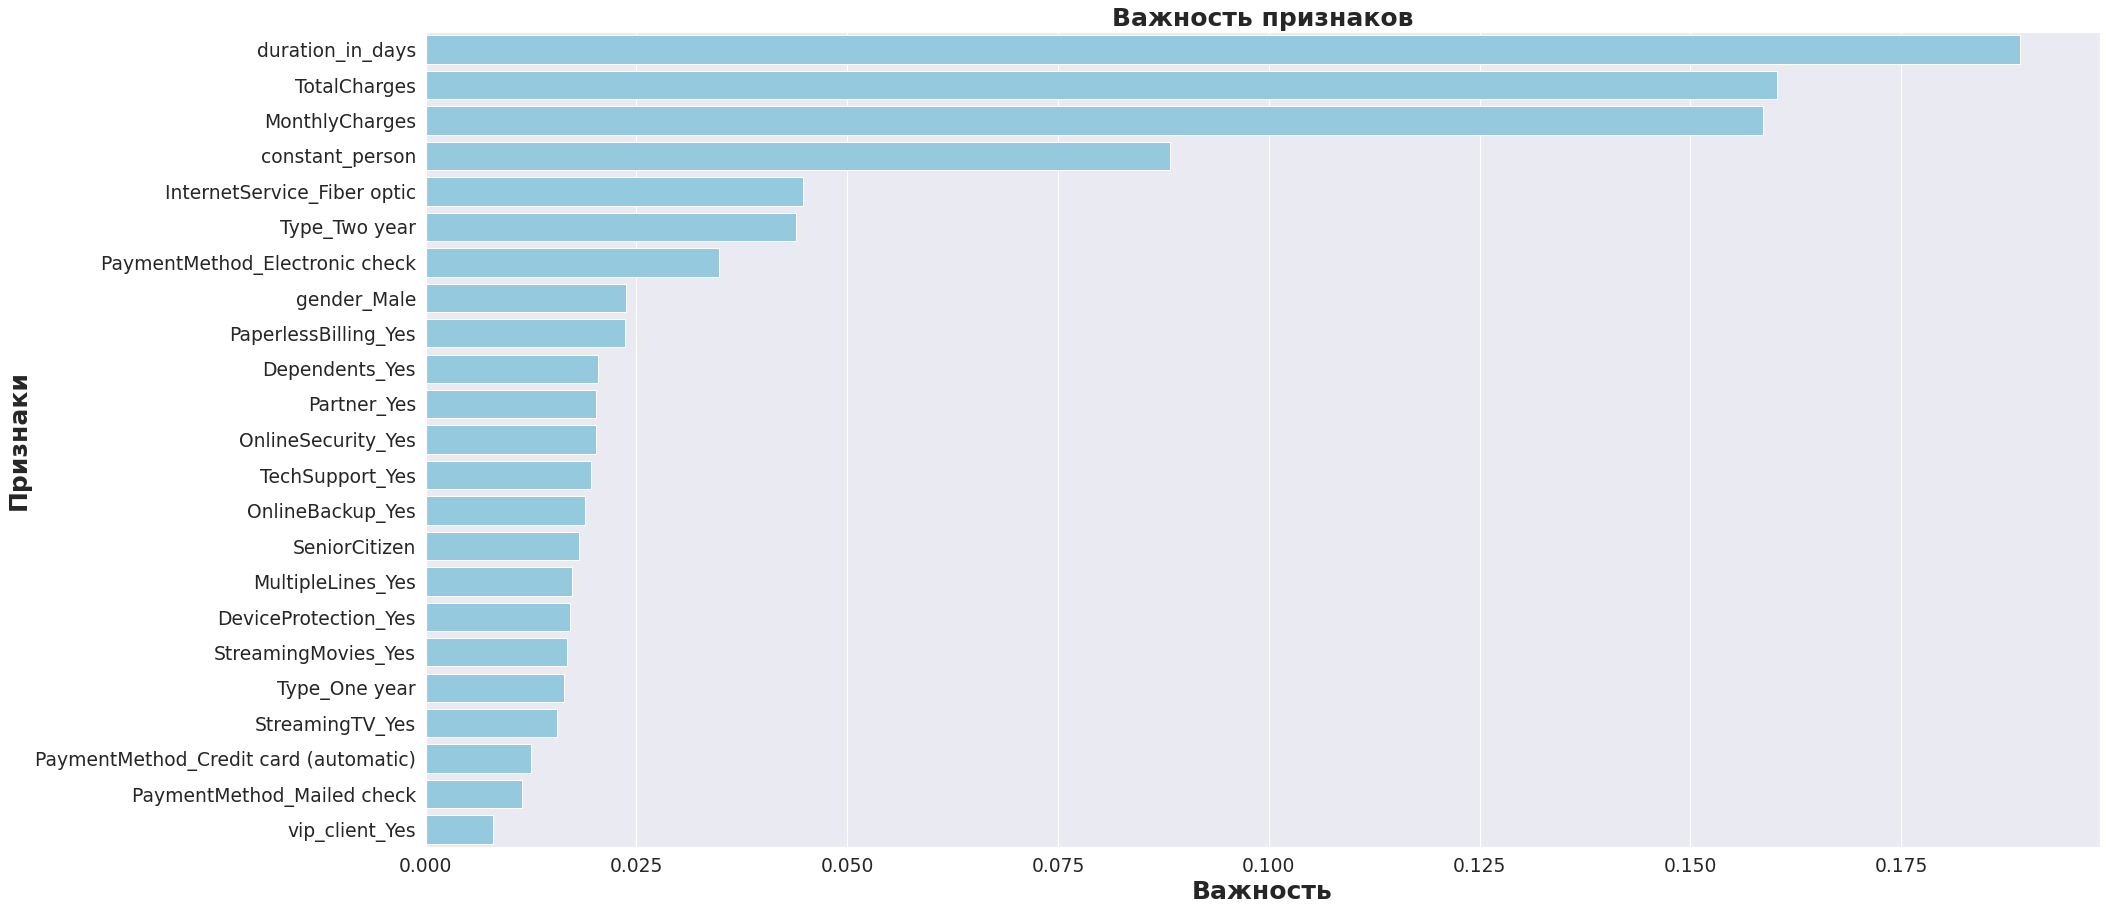

None

,Features,Gini-Importance
0,duration_in_days,0.189074
1,TotalCharges,0.160328
2,MonthlyCharges,0.158588
3,constant_person,0.088247
4,InternetService_Fiber optic,0.044764
5,Type_Two year,0.043932
6,PaymentMethod_Electronic check,0.034839
7,gender_Male,0.023757
8,PaperlessBilling_Yes,0.023614
9,Dependents_Yes,0.020435


In [74]:
feature_importances(rf_fitted)

**CatBoostClassifier**

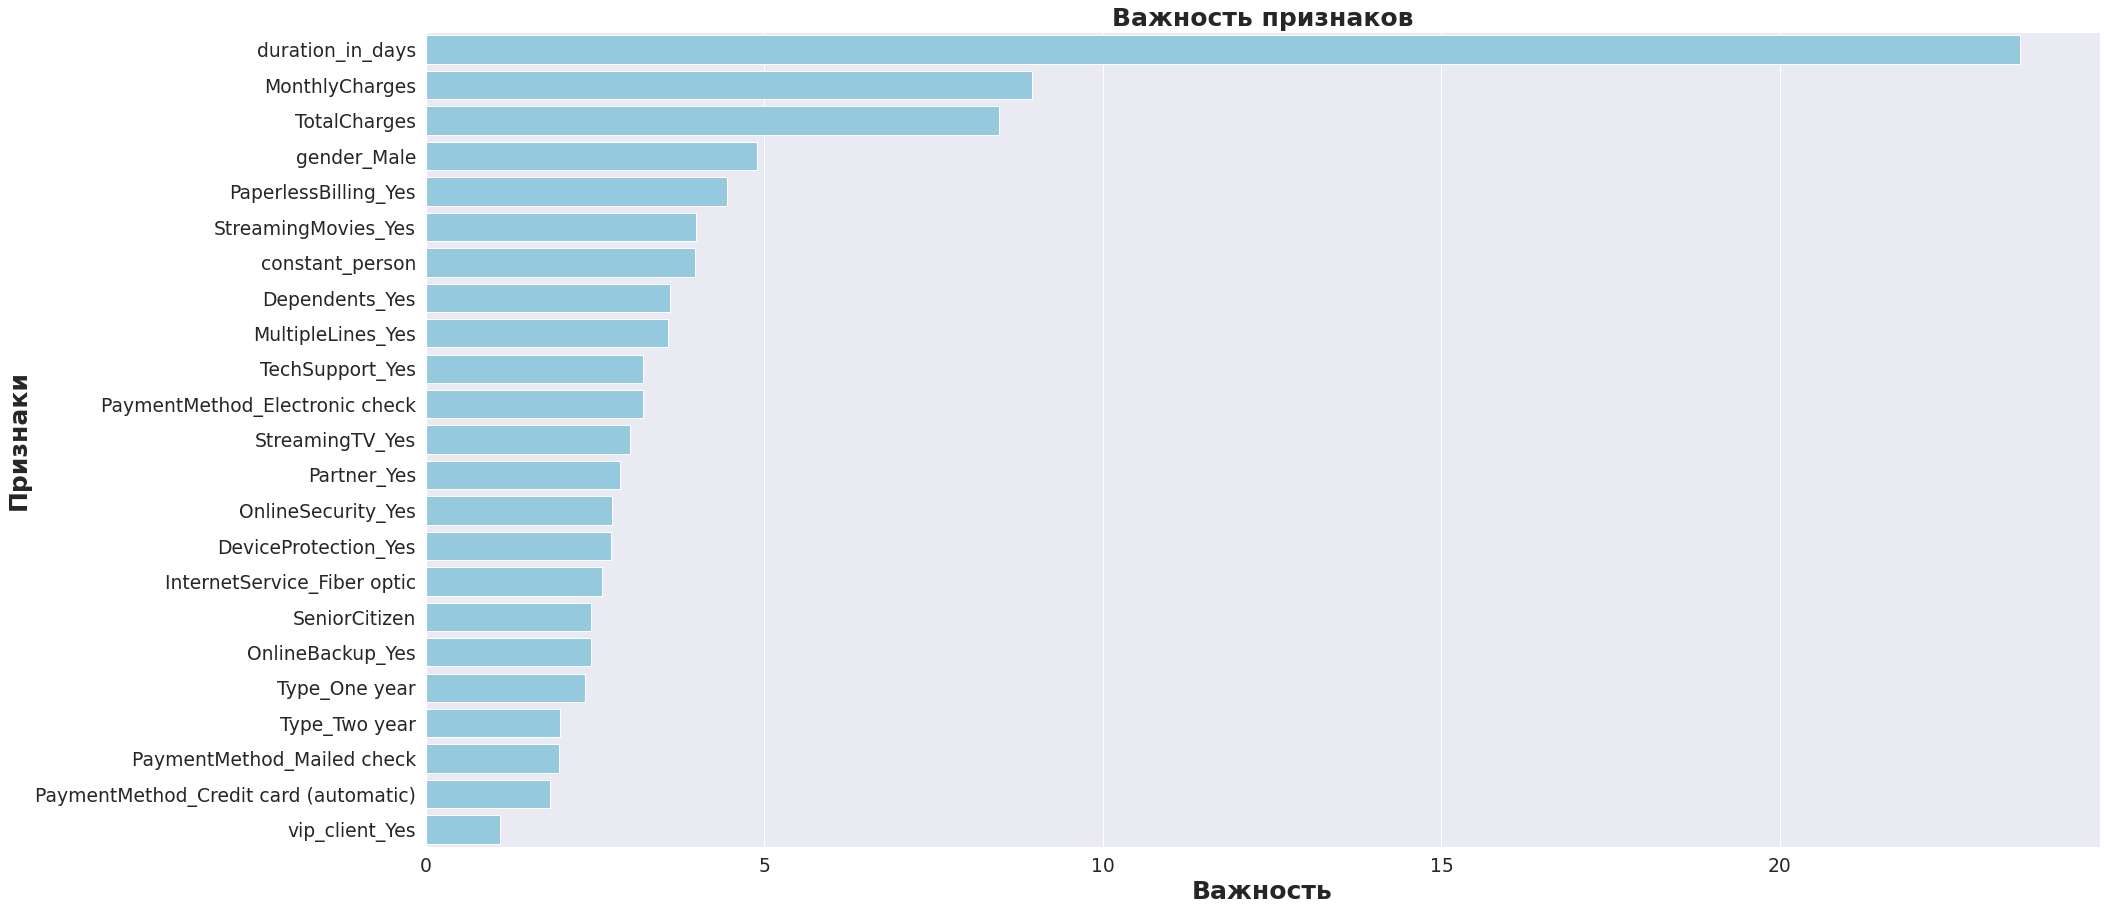

None

,Features,Gini-Importance
0,duration_in_days,23.542233
1,MonthlyCharges,8.959221
2,TotalCharges,8.460724
3,gender_Male,4.899590
4,PaperlessBilling_Yes,4.457778
5,StreamingMovies_Yes,3.986227
6,constant_person,3.976524
7,Dependents_Yes,3.602603
8,MultipleLines_Yes,3.582465
9,TechSupport_Yes,3.206967


In [75]:
feature_importances(CatBoost_fitted)

**XGBClassifier**

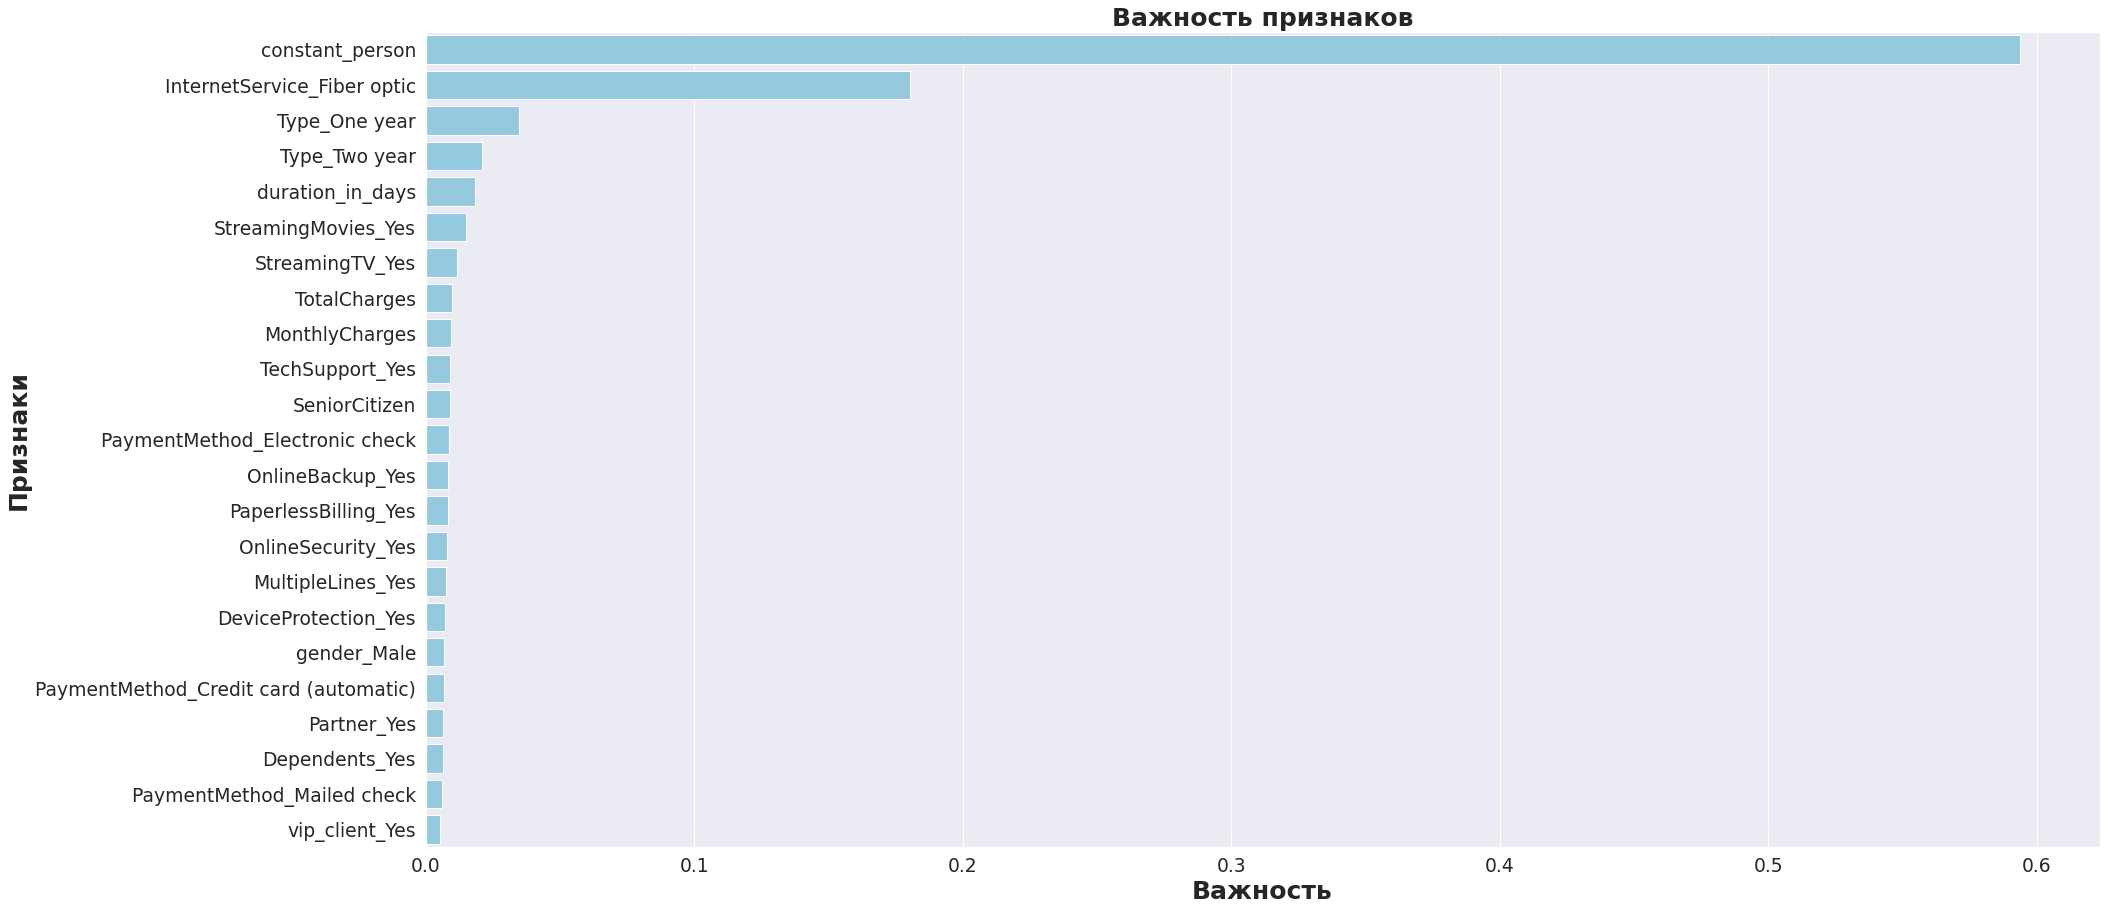

None

,Features,Gini-Importance
0,constant_person,0.593650
1,InternetService_Fiber optic,0.180426
2,Type_One year,0.034944
3,Type_Two year,0.020991
4,duration_in_days,0.018582
5,StreamingMovies_Yes,0.014934
6,StreamingTV_Yes,0.011655
7,TotalCharges,0.009986
8,MonthlyCharges,0.009488
9,TechSupport_Yes,0.009241


In [76]:
feature_importances(xgb_clf_fitted)

**LGBM**

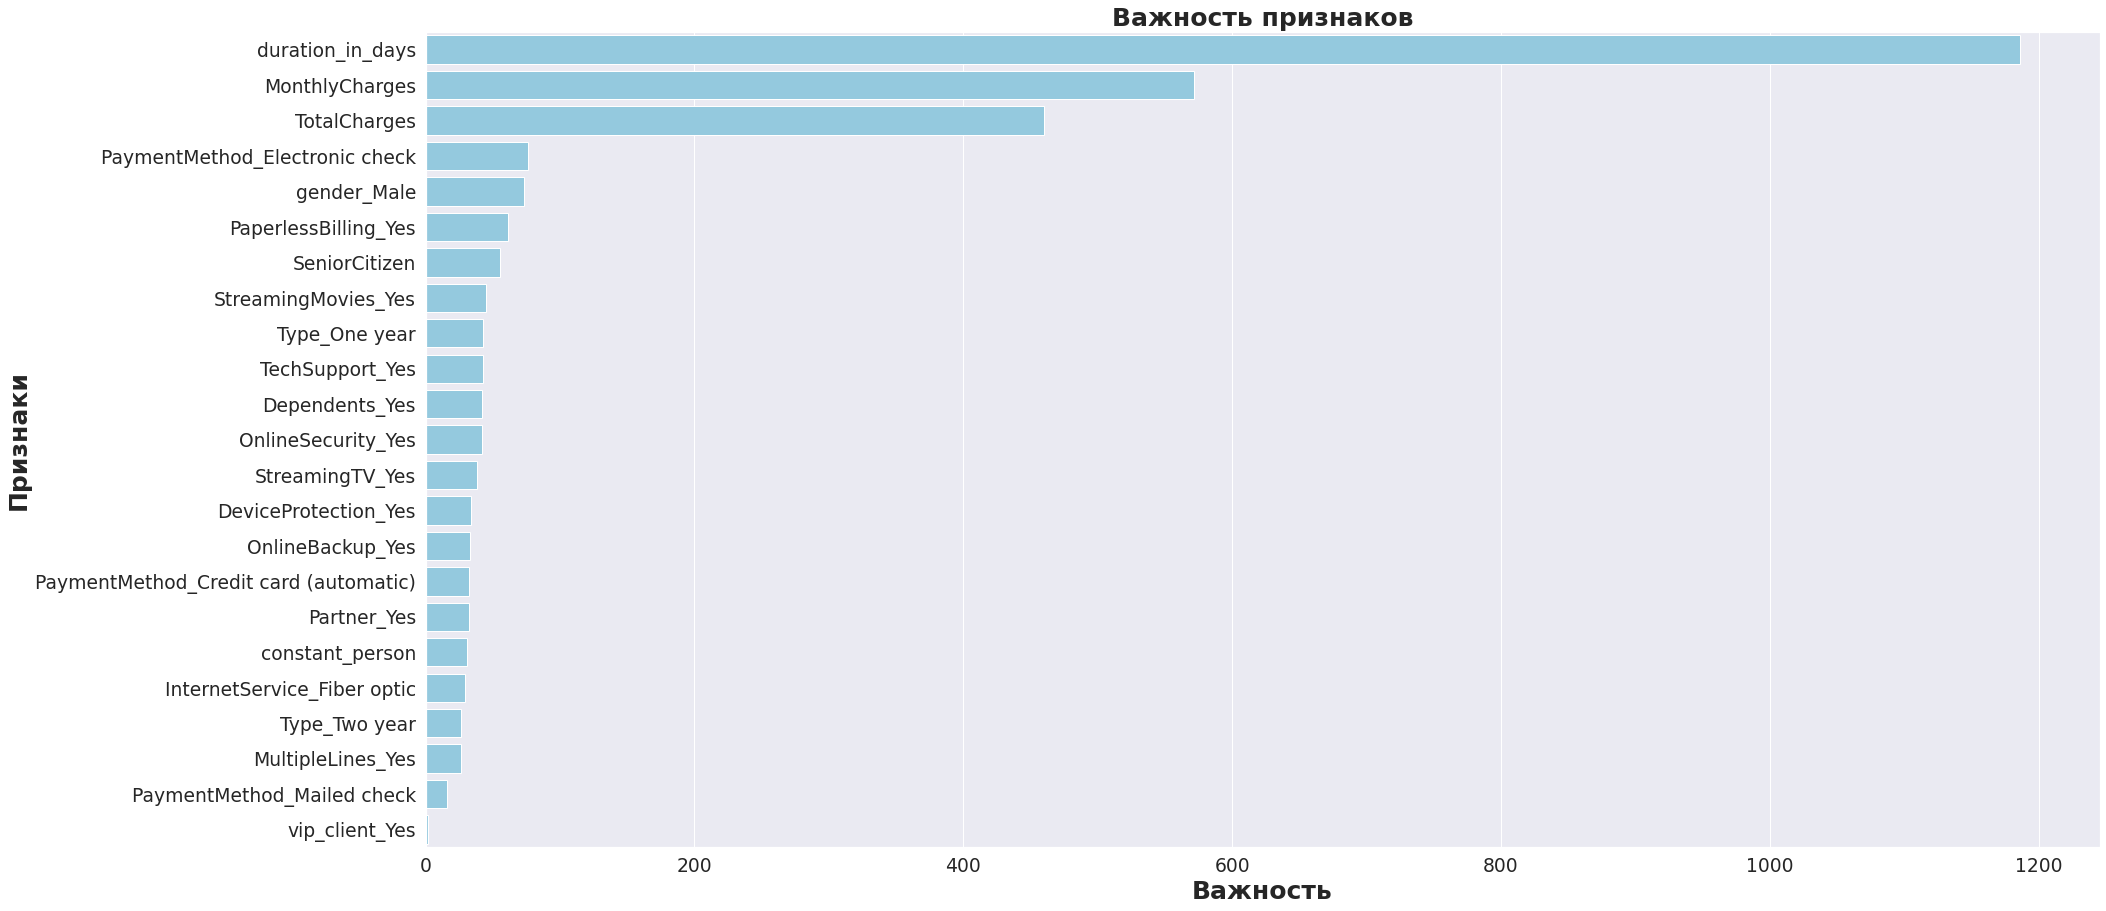

None

,Features,Gini-Importance
0,duration_in_days,1186
1,MonthlyCharges,572
2,TotalCharges,460
3,PaymentMethod_Electronic check,76
4,gender_Male,73
5,PaperlessBilling_Yes,61
6,SeniorCitizen,55
7,StreamingMovies_Yes,45
8,Type_One year,43
9,TechSupport_Yes,43


In [77]:
feature_importances(lgbm_clf_fitted)

<div class="alert alert" style="border-color: red; border-radius: 5px">
    <p><u><b> КОММЕНТАРИЙ СТУДЕНТА по 2 вопросу</b></u></p>
    
*Метод feature_importances позволил определить наиболее значимыми следующие признаки:*

1. MonthlyCharges    
    
2. duration_in_days
    
3. TotalCharges

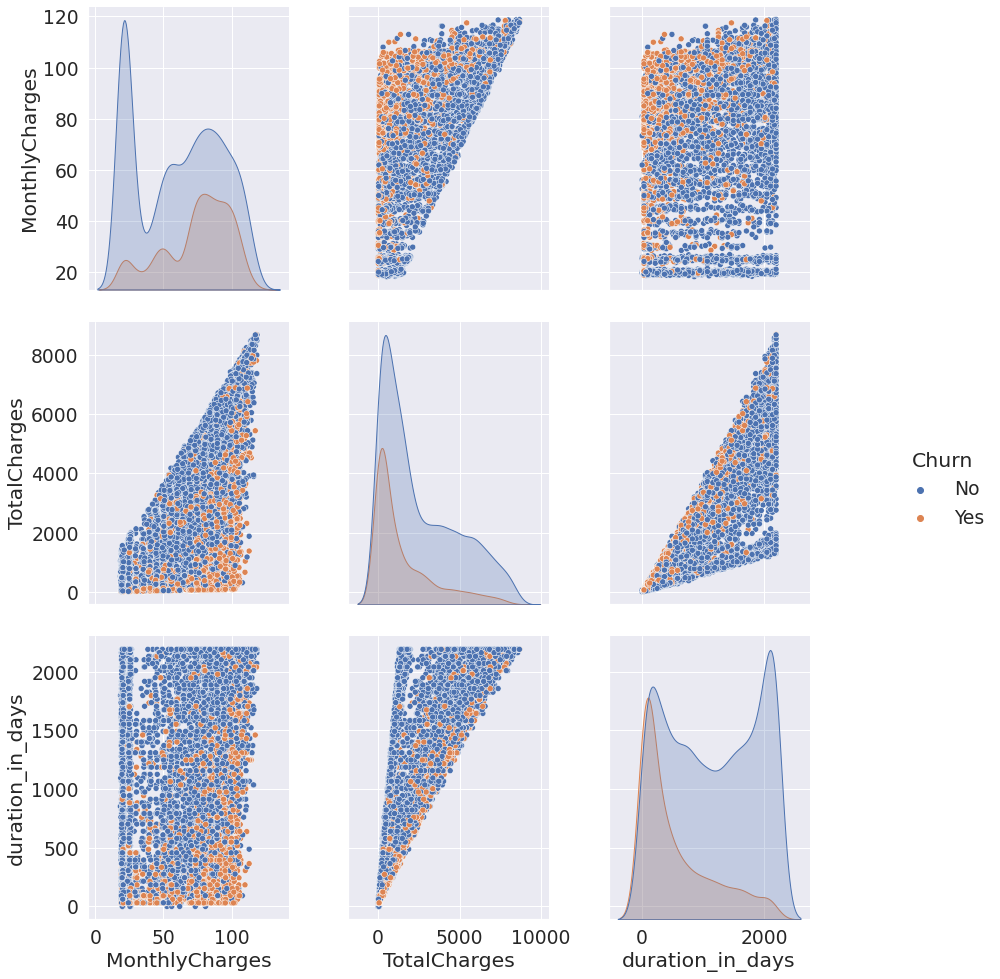

In [78]:
sns.pairplot(df_contract, hue='Churn').fig.set_size_inches(15,15)

In [79]:
df_contract.corr()

,MonthlyCharges,TotalCharges,duration_in_days
MonthlyCharges,1.000000,0.651182,0.247754
TotalCharges,0.651182,1.000000,0.826095
duration_in_days,0.247754,0.826095,1.000000


<div class="alert alert" style="border-color: red; border-radius: 5px">
    <p><u><b> КОММЕНТАРИЙ СТУДЕНТА по 1 вопросу:</b></u></p>
    
"1)При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас? Если есть - надо решать по понятиям:) (удалить лишнее) У тебя расчёт есть, но выводы не обозначены чётко."

*Повторюсь в чём то, надеюсь речь шла именно про это, поэтому посмотрел как эти признаки коррелируют между собой, с разделением на тех кто ушел и лояльных и ещё раз посмотрел корреляцию:*
    
    MonthlyCharges - видно что уходят в основном те, кто получает большие счета за услуги, что логично
    
    TotalCharges - почти одинаково распределен для тех кто ушел и кто лоялен
    
    duration_in_days - уходят в основном на первых месяцах, для лояльных примерно равномерно
    
    Сильно коррелируют duration_in_days и TotalCharges (линейно-зависимы, чуть слабее MonthlyCharges и TotalCharges(те, кто тратит на услуги больше, в целом приносит соответственно много дохода компании)
    
**Мультиколлинеарность не наблюдается, её значение не превышает значение 0.8**

# Общий вывод проекта

<div style="border-radius: 20px; border: 5px solid indigo; padding: 20px; ">
    
1. Исследовательский анализ данных позволил определить группы пользователей,а также пользователей склонных к уходу. Уже на этом этапе исследований можно предпринять определенные действия
    
2. В ходе проекта с использованием различных моделей машинного обучения были получены метрики вероятности ухода клиента.
    
3. Accuracy: 0.86 AUC-ROC: 0.92 То есть с вероятностью 86% модели могут предугадать, уйдет конкретный клиент или нет.
    
4. Лучшая модель по значению AUC-ROC - LGBMClassifier
    
5. Полученные значения AUC-ROC = 0.92 удовлетворяют требованиям к заданию AUC-ROC >= 0.88
    
6. Мультиколлинеарность не наблюдается, её значение не превышает значение 0.8

*P.P.S. Проект достаточно интересный,а самое главное имеет практическое применение. В проекте пришлось вспомнить практически весь ранее используемый материал, что позволило ещё раз закрепить полученные знания. К счастью в прошлых проектах уже были выведены определенные фомулы, использованы функции для моделей, поэтому в этом проекте они спасли кучу времени. **Большое спасибо за предоставленный материал, спасибо всей команде яндекс практикум за новые интересные знания**!*